In [1]:
import pandas as pd
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from tqdm import tqdm
dataroot = os.path.join("data")

# Feature extraction
$M_{book,user}\times M_{user,course} = M_{book,course}$

### Build $M_{user,course}$

Being saved at: ./data/course/usercoursedense.csv(npy)

In [2]:
usercourse={}
with open(os.path.join(dataroot, "course","commonuser_course.json"), "r", encoding='utf-8') as jf:
     usercourse= json.load(jf)

In [3]:
all_course = list(usercourse.values())
course_set = set()
for u_c in all_course:
    for c in u_c:
        course_set.add(c)
course_set= list(course_set)
course_set = sorted(course_set)
print(len(course_set))    

7129


In [4]:
with open(os.path.join(dataroot, "course", "courselist.txt"),"w+") as courslistefile:
    for i in course_set:
        courslistefile.write(f"{i}\n")


In [5]:
all_users = list(usercourse.keys())
print(len(all_users))

21829


In [ ]:
user_course_df = pd.DataFrame(
    columns=["uid"]+course_set, 
    data = np.zeros((len(all_users), len(course_set)+1))
)
user_course_df['uid'] = user_course_df['uid'].astype(str)
user_course_df.head()

In [ ]:
idx = 0 
for userid, courses in tqdm(usercourse.items()):

    user_course_df.iloc[
        idx, user_course_df.columns.get_loc('uid')
    ] = userid
    for c in courses:
        user_course_df.iloc[
            idx, user_course_df.columns.get_loc(c)
        ] = 1
    
    idx += 1

user_course_df.head()

In [17]:
user_course_df.shape

(21829, 7130)

In [18]:
user_course_df = user_course_df.drop(
    columns=list(
        x for x in list(user_course_df.columns) 
        if x[0] == '9'
    )
)

In [19]:
user_course_df.shape

(21829, 7055)

In [21]:
user_course_matrix = (user_course_df.drop(columns=['uid'])).values


In [20]:
user_course_df.to_csv(
    os.path.join(dataroot, "course","usercoursedense.csv"),
    index = False
)

In [22]:
np.save(
    os.path.join(dataroot,"course","usercoursedense"),
    user_course_matrix
)

### Build $M_{book,user}$

#### For layer 3

it's been saved at : ./data/book/cate3_userdense.csv(.npy)

In [23]:
userbook = {}
with open(os.path.join(dataroot, "book", "commonuser_book.json"),"r") as jf:
    userbook = json.load(jf)


In [ ]:
col = list(userbook.keys())
book_user_df = pd.DataFrame(
    columns=col,
    data=np.zeros((1000, len(col)))
)
book_user_df.head()

In [ ]:
exp = []
for userid, cates in tqdm(userbook.items()):
    for c in cates:
        pref3 = c[:3]
        try:
            pref3 = int(pref3)
        except:
            exp.append(c)
            continue
        
        book_user_df.iloc[
            pref3, book_user_df.columns.get_loc(userid)
        ] += 1
book_user_df.head()        

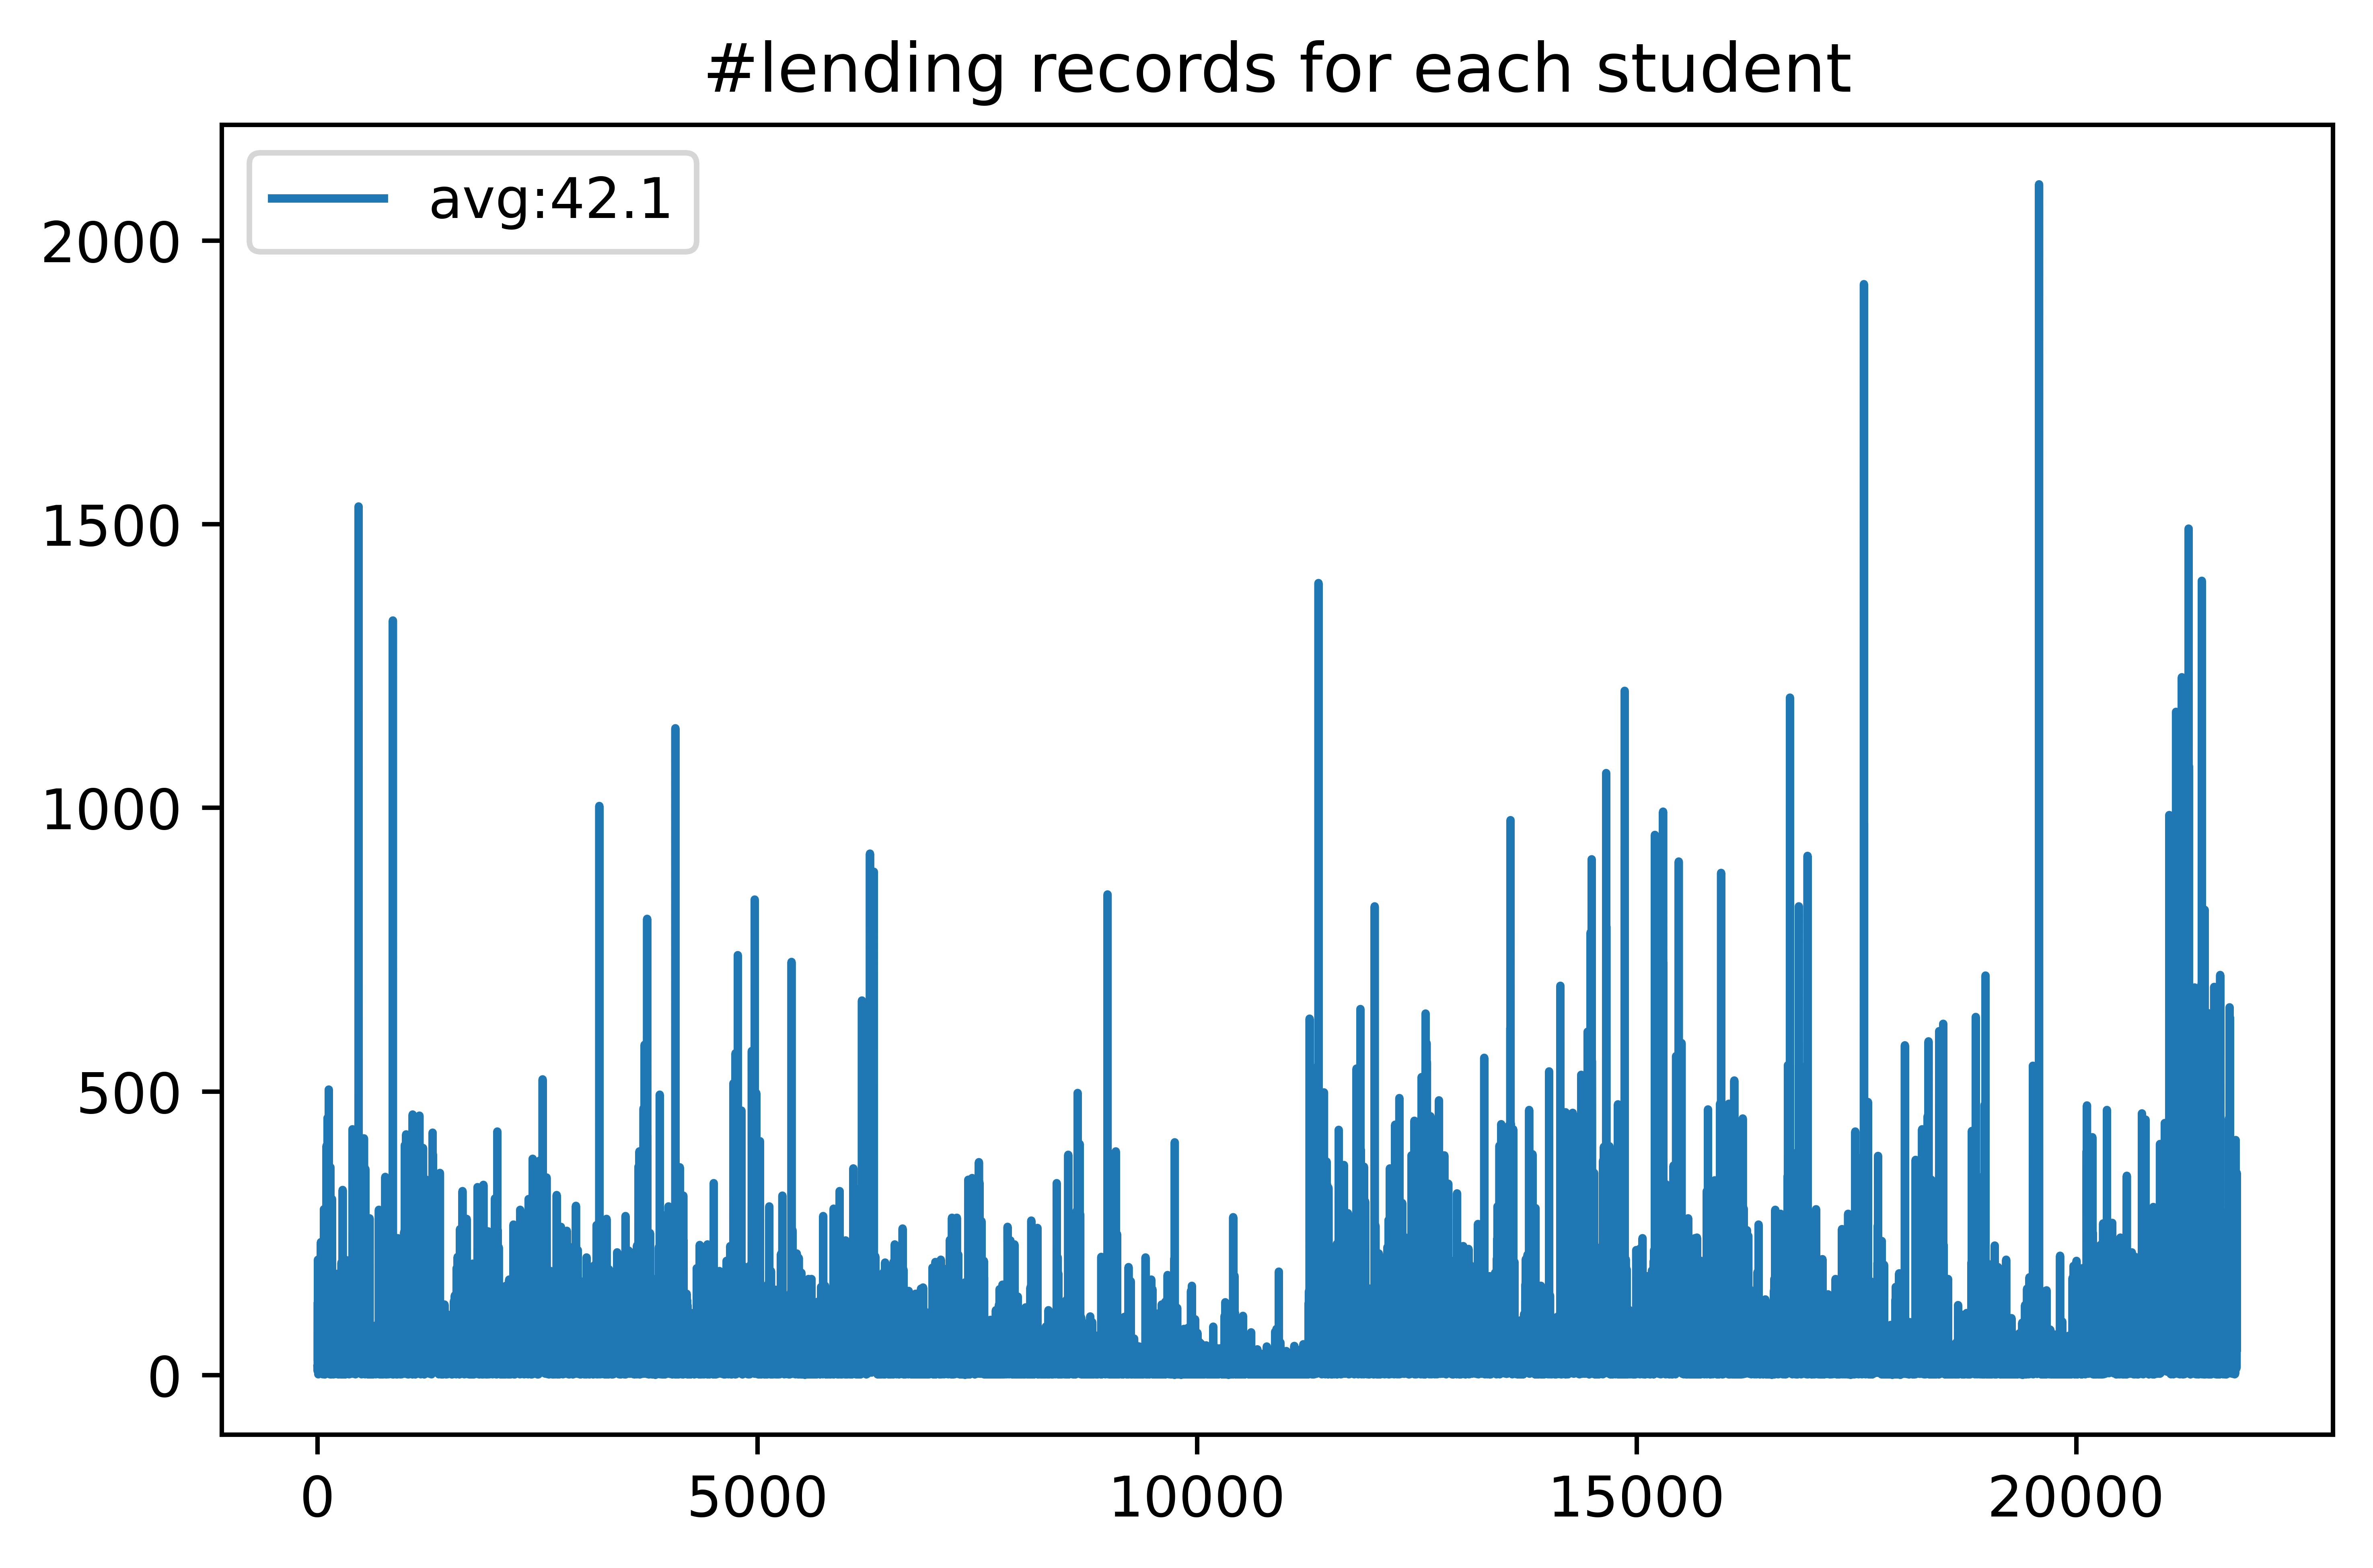

In [26]:
summa = np.sum(book_user_df.values, axis=0)

fig = plt.figure(dpi=1000)

plt.plot(
    list(i for i in range(book_user_df.shape[1])), 
    summa, label=f"avg:{np.mean(summa):.1f}"
)
plt.legend()
plt.title("#lending records for each student")

plt.tight_layout()
plt.show()


In [27]:
book_user_df.to_csv(
    os.path.join(dataroot, "book","cate3_userdense.csv"),
    index=False
)

In [28]:
np.save(
    os.path.join(dataroot, "book","cate3_userdense"),
    book_user_df.values    
)

### Matrix Mul

In [29]:
import torch
from sklearn.preprocessing import normalize
d = 'cuda' if torch.cuda.is_available() else 'cpu'

In [30]:
bookl3_user=np.load(
    os.path.join(dataroot, "book", "cate3_userdense.npy")
)

user_course=np.load(
    os.path.join(dataroot, "course", "usercoursedense.npy")
)

print(f"{bookl3_user.shape} x {user_course.shape}")

(1000, 21829) x (21829, 7054)


In [31]:
nor_user_course = normalize(user_course, axis=0, norm='l1')

In [32]:
bookl3_user_tensor = torch.tensor(
    bookl3_user, dtype=torch.float
).to(d)
user_couser_tensor = torch.tensor(
    nor_user_course, dtype = torch.float
).to(d)
book_course = torch.matmul(bookl3_user_tensor, user_couser_tensor).cpu()
book_course.size()

torch.Size([1000, 7054])

In [33]:
book_course = book_course.numpy()

np.save(
    os.path.join("result","bookcourse","matrix","origin"), 
    book_course
)

np.save(
    os.path.join("result","bookcourse","matrix","norm"), 
    normalize(book_course, axis=1)
)

## Visualization

In [34]:
book_course = np.load(
    os.path.join("result","bookcourse","matrix","norm.npy")
)

In [35]:
course_set = []
with open(os.path.join(dataroot, "course", "courselist.txt"), "r") as f:
    course_set = f.readlines()
course_set = list(map(lambda x: x.strip(), course_set))

In [36]:
def matrixDensity(m, savepath=None):
    fig = plt.figure(figsize=(20,10))
    #ax = fig.add_subplot(1,1,1)
    img = plt.imshow(
        -m , 
        interpolation='nearest', 
        aspect='auto', cmap=plt.cm.ocean
    )
    plt.colorbar() 
    if savepath is not None:
        plt.savefig(
            savepath,
            pad_inches=0,bbox_inches='tight')
    else:
        plt.show()
    plt.close()

In [37]:
matrixDensity(
    m =book_course, 
    savepath=os.path.join("result","bookcourse", "densityplot","total.jpg")
)

In [ ]:
for i in tqdm(range(10,90)):
    l = len(str(i))
    cix = list(idx for idx,c in enumerate(course_set) if c[:l]==str(i))
    if not len(cix):
        continue
    cixbook = book_course[:,cix]
    if cixbook.shape[1] == 0:
        continue
    savedir = os.path.join(
        "result","bookcourse","densityplot",f"{str(i)[0]}"
    )
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    
    matrixDensity(
        cixbook, savepath=os.path.join(savedir, f"{i}.jpg")
    )
